In [1]:
import json 
import numpy as np 
# folder_loc = "C:/Users/tomms/Desktop/spotify data 1yr"
folder_loc = "C:/Users/tomms/Desktop/All Spotify Data/continuous"
histories = []
for i in range(10):
    filename = folder_loc + "/StreamingHistory" +  format(i) + ".json" 
    histories.append(np.asarray(json.loads((open(filename, "r")).read())))
full_history = histories[0]
for i in range(1,10): 
    full_history = np.concatenate((full_history, histories[i]))


In [2]:
def extractAllOfFeature(feature, history = full_history): 
    feature_data = [] 
    for item in history: 
        feature_data.append(item[feature])
    return np.asarray(feature_data)
def extractDictsOfFeature(feature, featureVal, history = full_history):
    feature_data = [] 
    for item in history: 
        if item[feature] == featureVal: 
            feature_data.append(item) 
    return np.asarray(feature_data)
def extractFeature(feature, featureVal, history = full_history): 
    feature_data = [] 
    for item in history: 
        if item[feature] == featureVal: 
            feature_data.append(item[feature])
    return np.asarray(feature_data)


In [3]:
def extractThisFromThat(this, that, thatVal):
    this_list = [] 
    for item in full_history: 
        if item[that] == thatVal: 
            this_list.append(item[this])
    return np.array(this_list)

In [4]:
import numpy as np
from datetime import datetime

def get_just_dates(datetimes):
    dates = []
    for date_time in datetimes:
        datetime_obj = datetime.strptime(date_time, '%Y-%m-%d %H:%M')
        date_str = datetime_obj.strftime('%Y-%m-%d')
        dates.append(date_str)
    return np.asarray(dates)

In [5]:
playlist_file = folder_loc + "/Playlist1.json"
playlists_dict = json.loads((open(playlist_file, "r")).read())
playlists_dict = playlists_dict['playlists']

In [6]:
def get_playlist(name):
    for playlist in playlists_dict: 
        if playlist['name'] == name: 
            return playlist
    return None 
def song_in_playlist(song, playlist):
    tracks = get_playlist(playlist)['items']
    for track in tracks: 
        if track['track']['trackName'] == song:
            return True 
    return False

def get_playlist_history(playlistName, history = full_history):
    playlist_history = []
    for item in history:
        if song_in_playlist(item['trackName'], playlistName):
            playlist_history.append(item)
    return np.asarray(playlist_history)


In [65]:
import matplotlib.pyplot as plt 
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size":    "16.0",
    "figure.figsize" : "9, 6",
    "axes.titlesize": "medium",
    "figure.titlesize": "medium"
})

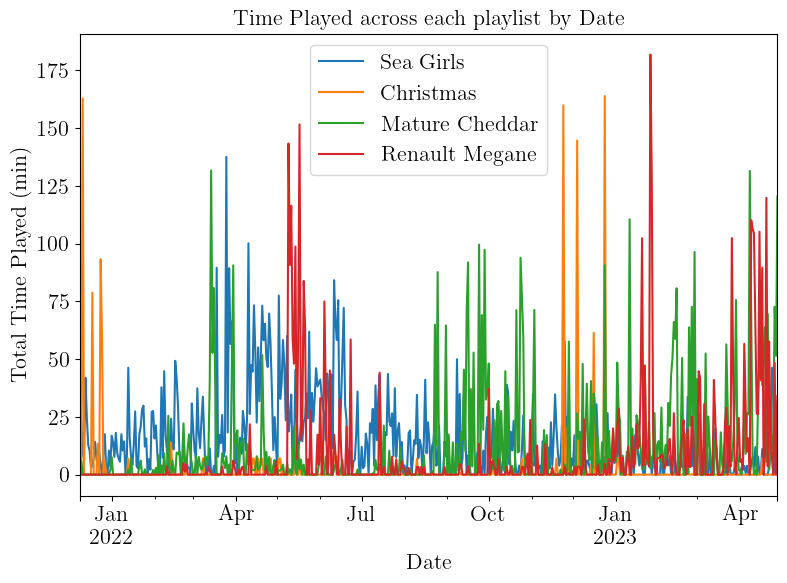

In [67]:
import pandas as pd 

# create a range of dates from 2021-12-09 to 2023-04-28
date_range = pd.date_range(start='2021-12-09', end='2023-04-28', freq='D')
playlists_to_plot = ['Christmas', 'Mature Cheddar', 'Renault Megane']
artists = ['Sea Girls']
# artists = ['Courteeners', 'The Wombats', 'Sea Girls', 'Dave', 'Two Door Cinema Club', 'Blossoms']

# create a DataFrame with the date range as the index
df = pd.DataFrame(index=date_range)

for artist in artists:
    artist_history = extractDictsOfFeature('artistName', artist)
    ms_played = extractAllOfFeature('msPlayed', artist_history) / (1000 * 60)
    end_times = extractAllOfFeature('endTime', artist_history)
    dates = pd.to_datetime(get_just_dates(end_times))
    
    # create a Series with the total time played on each date and reindex it using the date range
    total_time = pd.Series([ms_played[dates == d].sum() for d in date_range], index=date_range, name=artist)
    # add the Series to the DataFrame
    df[artist] = total_time

for playlist in playlists_to_plot:
    playlist_history = get_playlist_history(playlist)
    ms_played = extractAllOfFeature('msPlayed', playlist_history) / (1000 * 60)
    end_times = extractAllOfFeature('endTime', playlist_history)
    dates = pd.to_datetime(get_just_dates(end_times))

    # create a Series with the total time played on each date and reindex it using the date range
    total_time = pd.Series([ms_played[dates == d].sum() for d in date_range], index=date_range, name=playlist)

    if playlist == 'Christmas':
        total_time = total_time*2
    if playlist == 'Mature Cheddar':
        total_time /= 2
    df[playlist] = total_time

# for col in df.columns: 
#     plt.scatter(date_range, df[col])
# plt.show()

df.plot() #"."
plt.xlabel('Date')
plt.ylabel('Total Time Played (min)')
title = "Time Played across each playlist by Date"
plt.title(title)
plt.savefig(title + ".png", format = "png", dpi = 500, bbox_inches = 'tight')#i've done 9 by 6 for it 
# Show graph
plt.show()


In [44]:
def prepDataForObservations(artists, playlists):
    date_range = pd.date_range(start='2021-12-09', end='2023-04-28', freq='D')
    observations = []
    #Hold on, I'm going to need figure something out because I don't have the same number of actions per day 
    #Actually this doesn't matter. 
    for artist in artists:
        artist_history = extractDictsOfFeature('artistName', artist)
        ms_played = extractAllOfFeature('msPlayed', artist_history) / (1000 * 60)
        end_times = extractAllOfFeature('endTime', artist_history)
        dates = pd.to_datetime(get_just_dates(end_times))
        
        total_time = [ms_played[dates == d].sum() for d in date_range]
        for i in range(len(total_time)):     
            #either I do this and change the other code or;
            # if total_time[i] >= 0.5: 
            #     observations.append([0, artist, date_range[i], round(total_time[i])])
            
            #or I do this and then I can just plug it straight into my other code 
            for _ in range(round(total_time[i])):
                observations.append([0, artist, i]) #change to data_range[i] if you want the actual date 

    for playlist in playlists:
        playlist_history = get_playlist_history(playlist)
        ms_played = extractAllOfFeature('msPlayed', playlist_history) / (1000 * 60)
        end_times = extractAllOfFeature('endTime', playlist_history)
        dates = pd.to_datetime(get_just_dates(end_times))

        total_time = np.asarray([ms_played[dates == d].sum() for d in date_range])
        if playlist == 'Christmas':
            total_time = total_time*2
        if playlist == 'Mature Cheddar':
            total_time /= 2
        for i in range(len(total_time)):     
            #either I do this and change the other code or;
            # if total_time[i] >= 0.5: 
            #     observations.append([0, artist, date_range[i], round(total_time[i])])
            
            #or I do this and then I can just plug it straight into my other code 
            for _ in range(round(total_time[i])):
                observations.append([0, playlist, i])
    return observations

In [45]:
playlists_to_plot = ['Christmas', 'Mature Cheddar', 'Renault Megane']
artists = ['Sea Girls']
observations = prepDataForObservations(artists, playlists_to_plot)

In [46]:
np_observations = np.asarray(observations) 
n_observations = np.count_nonzero(np.unique(np_observations[:,2]))
observation_times = np.unique(np_observations[:,2]).astype(int)
observation_times = np.sort(observation_times)
print(n_observations) #some days won't have anything on them so we need to not look there. 

470


In [47]:
np_observations = np.asarray(observations)
actions = ['Sea Girls', 'Christmas', 'Mature Cheddar', 'Renault Megane']

for i in range(len(actions)):
    np_observations[:,1] = np.where(np_observations[:,1]==actions[i], i, np_observations[:,1])

np_observations = np_observations.astype(int)
print(np_observations[:,2])

mapping = {val: i for i, val in enumerate(sorted(set(np_observations[:,2])))}
np_observations[:,2] = [mapping[val] for val in np_observations[:,2]]
print(np_observations.shape)

[  1   1   1 ... 505 505 505]
(19199, 3)


In [657]:
np.save('observations',np_observations)
np.save('observation_times', observation_times)

In [ ]:
smaller_observation_times = observation_times[0:210]
# np.save("smaller_observations", smaller_observations)
# np.save("smaller_observation_times", smaller_observation_times)

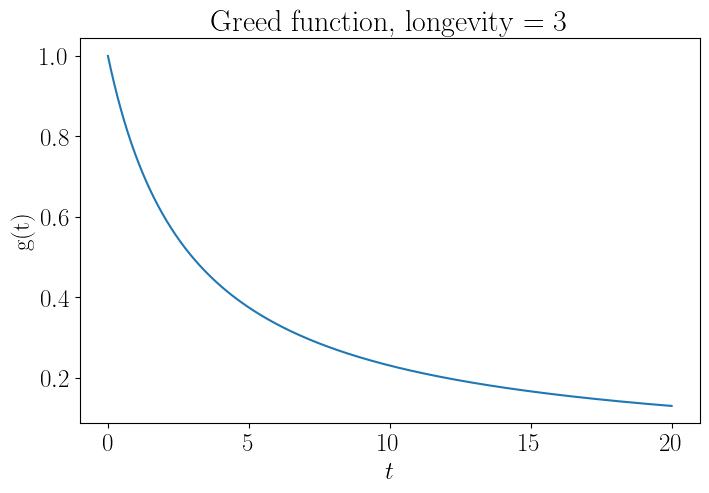

In [120]:
%reload_ext autoreload
%autoreload 2 
import math
import numpy as np 
from RewardFunctions import sawtooth
from RewardFunctions import SingleStateReward
from RewardFunctions import DoubleStateReward
from RewardFunctions import greed 
t = np.linspace(0,20,1500)
# a = np.linspace(0,9,1500)
# R = SingleStateReward(5, 10, sigma = 1)
#again idk why I don't let them define sigma here 
# R = DoubleStateReward(R_max = 5, n_actions = 10, greed_longevity = 3) # pretty sure 3 is the default 
# plt.plot(t, R(0,0,t), label = "a = 0")
# plt.plot(t, R(0,4,t), label = "a = 4")
# for t in [0,2,4,6,8,10]:
#     # plt.plot(a, R(0,a,t), label = "t = " + format(t))
#     y = [] 
#     for a_ in a: 
#         y.append(R(1,a_,t))
#     plt.plot(a, y, label = "t = " + format(t)) 


# plt.plot(t, sawtooth(t, 5))
plt.plot(t, greed(t,3))
plt.xlabel("$t$")
# plt.ylabel("$f(t, k=5)$")
plt.ylabel("g(t)")
# plt.ylabel("$R(1,a,t)$")
title = "Greed function, longevity = 3"
plt.title(title)
plt.savefig(title + ".png", format = "png", dpi = 500, bbox_inches = 'tight')
plt.show()